In [1]:
using Pkg
Pkg.activate("../../..")

  Activating project at `~/Documents/Git/StockFlow.jl`


In [2]:
using GraphViz

using StockFlow
using StockFlow.Syntax
using StockFlow.Syntax.Stratification
using StockFlow.Syntax.Rewrite

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz



In [3]:
using StockFlow.Syntax.Stratification
using StockFlow.Syntax.Rewrite

In [4]:
# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) = 
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle", 
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)

GraphF_typed (generic function with 5 methods)

# Stratify an SIR model (need graph rewriting to redefine the mixing contact part)

### 1.1 define the type stock and flow diagram (common part)

In [5]:
s_type = @stock_and_flow begin
    :stocks
    pop
    
    :parameters
    c
    β
    rFstOrder
    rAge
    
    :dynamic_variables
    v_prevalence = pop / N
    v_meanInfectiousContactsPerS = c * v_prevalence
    v_perSIncidenceRate = β * v_meanInfectiousContactsPerS
    v_inf = pop * v_perSIncidenceRate
    v_fstOrder = pop * rFstOrder
    v_aging = pop * rAge
    
    :flows
    pop => f_inf(v_inf) => pop
    pop => f_fstOrder(v_fstOrder) => pop
    pop => f_aging(v_aging) => pop

    
    :sums
    N = [pop]
    
    
end


StockAndFlowF {S:1, SV:1, LS:1, F:3, I:3, O:3, V:6, LV:4, LSV:1, P:4, LVV:3, LPV:4, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │   pop │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────────┐
│ F │ fv │      fname │
├───┼────┼────────────┤
│ 1 │  4 │      f_inf │
│ 2 │  5 │ f_fstOrder │
│ 3 │  6 │    f_aging │
└───┴────┴────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  1 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  1 │
└───┴─────┴────┘
┌───┬──────────────────────────────┬─────┐
│ V │                        vname │ vop │
├───┼──────────────────────────────┼─────┤
│ 1 │                 v_prevalence │   / │
│ 2 │ v_meanInfectiousContactsPerS │   * │
│ 3 │          v_perSIncidenceRate │   * │
│ 4 │                        v_inf │   * │
│ 5 │                   v_fstOrder │   * │
│ 6 │                      v_aging │   * │
└───┴──────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   1 │           1 │
│  2 │   1 │   4 │           1 │
│  3 │   1 │   5 │           1 │
│  4 │   1 │   6 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────────┐
│ P │     pname │
├───┼───────────┤
│ 1 │         c │
│ 2 │         β │
│ 3 │ rFstOrder │
│ 4 │      rAge │
└───┴───────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             2 │
│   2 │     2 │     3 │             2 │
│   3 │     3 │     4 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    2 │            1 │
│   2 │    2 │    3 │            1 │
│   3 │    3 │    5 │            2 │
│   4 │    4 │    6 │            2 │
└─────┴──────┴──────┴──────────────┘

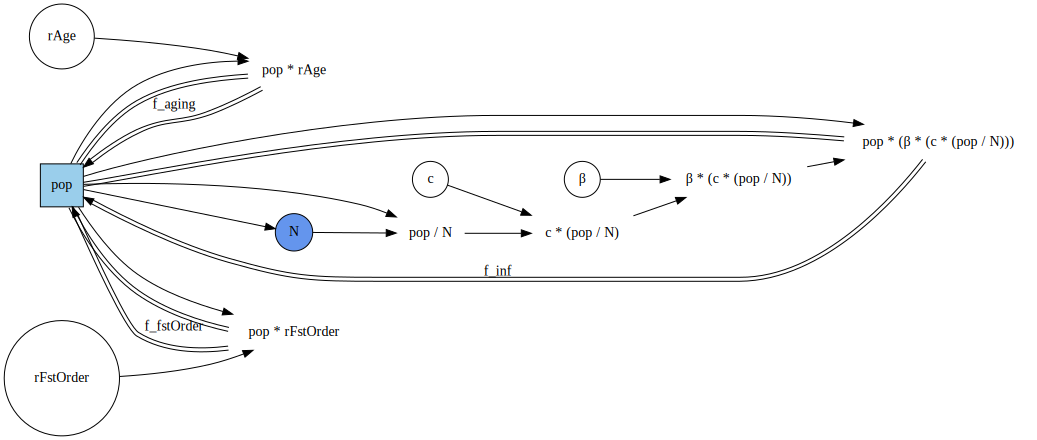

In [6]:
GraphF(s_type)

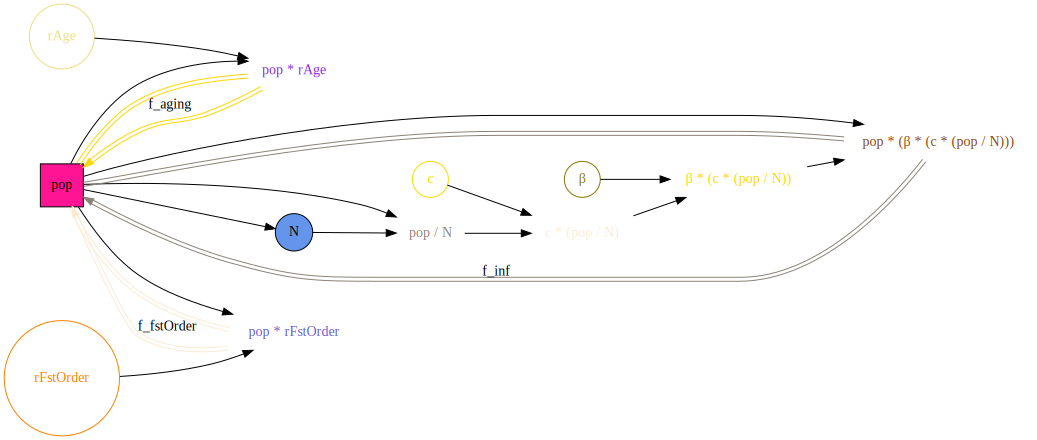

In [7]:
GraphF_typed(id(s_type))

## 1.2 define SIR model

In [8]:
sir = @stock_and_flow begin
    :stocks
    S
    I
    R
    
    :parameters
    c
    β
    rRec
    rAge
    
    :dynamic_variables
    v_prevalence = I / N
    v_meanInfectiousContactsPerS = c * v_prevalence
    v_perSIncidenceRate = β * v_meanInfectiousContactsPerS
    v_newInfections = S * v_perSIncidenceRate
    v_newRecovery = I * rRec
    v_idS = S * rAge
    v_idI = I * rAge
    v_idR = R * rAge
    
    :flows
    S => f_idS(v_idS) => S
    S => f_inf(v_newInfections) => I
    I => f_idI(v_idI) => I
    I => f_rec(v_newRecovery) => R
    R => f_idR(v_idR) => R
    
    :sums
    N = [S, I, R]
    
    
end

StockAndFlowF {S:3, SV:1, LS:3, F:5, I:5, O:5, V:8, LV:6, LSV:1, P:4, LVV:3, LPV:6, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     S │
│ 2 │     I │
│ 3 │     R │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
└────┴─────┴──────┘
┌───┬────┬───────┐
│ F │ fv │ fname │
├───┼────┼───────┤
│ 1 │  6 │ f_idS │
│ 2 │  4 │ f_inf │
│ 3 │  7 │ f_idI │
│ 4 │  5 │ f_rec │
│ 5 │  8 │ f_idR │
└───┴────┴───────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  2 │
│ 3 │   3 │  2 │
│ 4 │   4 │  3 │
│ 5 │   5 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  2 │
│ 4 │   4 │  2 │
│ 5 │   5 │  3 │
└───┴─────┴────┘
┌───┬──────────────────────────────┬─────┐
│ V │                        vname │ vop │
├───┼──────────────────────────────┼─────┤
│ 1 │                 v_prevalence │   / │
│ 2 │ v_meanInfectiousContactsPerS │   * │
│ 3 │          v_perSIncidenceRate │   * │
│ 4 │              v_newInfections │   * │
│ 5 │                v_newRecovery │   * │
│ 6 │                        v_idS │   * │
│ 7 │                        v_idI │   * │
│ 8 │                        v_idR │   * │
└───┴──────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   2 │   1 │           1 │
│  2 │   1 │   4 │           1 │
│  3 │   2 │   5 │           1 │
│  4 │   1 │   6 │           1 │
│  5 │   2 │   7 │           1 │
│  6 │   3 │   8 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │     c │
│ 2 │     β │
│ 3 │  rRec │
│ 4 │  rAge │
└───┴───────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             2 │
│   2 │     2 │     3 │             2 │
│   3 │     3 │     4 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    2 │            1 │
│   2 │    2 │    3 │            1 │
│   3 │    3 │    5 │            2 │
│   4 │    4 │    6 │            2 │
│   5 │    4 │    7 │            2 │
│   6 │    4 │    8 │            2 │
└─────┴──────┴──────┴──────────────┘

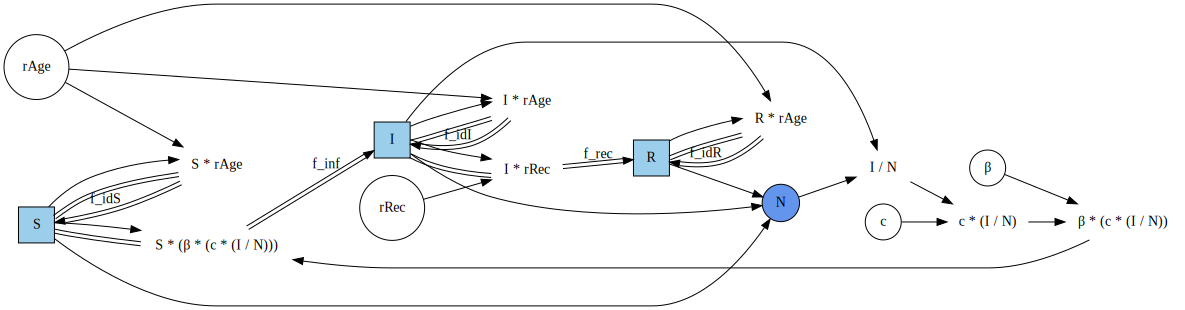

In [9]:
GraphF(sir)

In [10]:
GraphF_typed(typed_aggregate_model)

UndefVarError: UndefVarError: `typed_aggregate_model` not defined

## 1.3 define the age structure diagram

In [11]:
age2 = @stock_and_flow begin
    :stocks
    Child
    Adult
    
    :parameters
    c_C
    β
    r
    rAge
    c_A
    
    :dynamic_variables
    v_INC = Child / NC
    v_cINC = c_C * v_INC
    v_cβINC = β * v_cINC
    
    v_infC = Child * v_cβINC
    v_fstC = Child * r
    v_agingC = Child * rAge
    
    
    v_INA = Adult / NA
    v_cINA = c_A * v_INA
    v_cβINA = β * v_cINA
    
    v_infA = Adult * v_cβINA
    v_fstA = Adult * r
    
    :flows
    Child => f_infC(v_infC) => Child
    Child => f_frsC(v_fstC) => Child
    Child => f_aging(v_agingC) => Adult
    Adult => f_infA(v_infA) => Adult
    Adult => f_frsA(v_fstA) => Adult
    
    
    :sums
    NC = [Child]
    NA = [Adult]
end

StockAndFlowF {S:2, SV:2, LS:2, F:5, I:5, O:5, V:11, LV:7, LSV:2, P:5, LVV:6, LPV:7, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │ Child │
│ 2 │ Adult │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │     NC │
│  2 │     NA │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    2 │
└────┴─────┴──────┘
┌───┬────┬─────────┐
│ F │ fv │   fname │
├───┼────┼─────────┤
│ 1 │  4 │  f_infC │
│ 2 │  5 │  f_frsC │
│ 3 │  6 │ f_aging │
│ 4 │ 10 │  f_infA │
│ 5 │ 11 │  f_frsA │
└───┴────┴─────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  2 │
│ 4 │   4 │  2 │
│ 5 │   5 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  1 │
│ 4 │   4 │  2 │
│ 5 │   5 │  2 │
└───┴─────┴────┘
┌────┬──────────┬─────┐
│  V │    vname │ vop │
├────┼──────────┼─────┤
│  1 │    v_INC │   / │
│  2 │   v_cINC │   * │
│  3 │  v_cβINC │   * │
│  4 │   v_infC │   * │
│  5 │   v_fstC │   * │
│  6 │ v_agingC │   * │
│  7 │    v_INA │   / │
│  8 │   v_cINA │   * │
│  9 │  v_cβINA │   * │
│ 10 │   v_infA │   * │
│ 11 │   v_fstA │   * │
└────┴──────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   1 │           1 │
│  2 │   1 │   4 │           1 │
│  3 │   1 │   5 │           1 │
│  4 │   1 │   6 │           1 │
│  5 │   2 │   7 │           1 │
│  6 │   2 │  10 │           1 │
│  7 │   2 │  11 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
│   2 │     2 │    7 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │   c_C │
│ 2 │     β │
│ 3 │     r │
│ 4 │  rAge │
│ 5 │   c_A │
└───┴───────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             2 │
│   2 │     2 │     3 │             2 │
│   3 │     3 │     4 │             2 │
│   4 │     7 │     8 │             2 │
│   5 │     8 │     9 │             2 │
│   6 │     9 │    10 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    2 │            1 │
│   2 │    2 │    3 │            1 │
│   3 │    3 │    5 │            2 │
│   4 │    4 │    6 │            2 │
│   5 │    5 │    8 │            1 │
│   6 │    2 │    9 │            1 │
│   7 │    3 │   11 │            2 │
└─────┴──────┴──────┴──────────────┘

In [12]:
GraphF_typed(typed_age_model)

UndefVarError: UndefVarError: `typed_age_model` not defined

## 1.4 Calculate pullback and recreate the stratified model

In [13]:
aged_sir = @stratify sir s_type age2 begin
    
    :parameters
    c => c <= c_C, c_A
    β => β <= β
    rRec => rFstOrder <= r
    rAge => rAge <= rAge

    :dynamic_variables
    v_prevalence => v_prevalence <= ~v_IN
    v_meanInfectiousContactsPerS => v_meanInfectiousContactsPerS <= ~v_cIN 
    v_perSIncidenceRate => v_perSIncidenceRate <= ~v_cβIN
    v_newInfections => v_inf <= ~v_inf
    v_newRecovery => v_fstOrder <= ~v_fst
    ~id => v_aging <= ~v_aging

    :flows
    f_inf => f_inf <= ~f_inf
    f_rec => f_fstOrder <= ~f_frs
    ~id => f_aging <= f_aging

end

StockAndFlowF {S:6, SV:2, LS:6, F:7, I:7, O:7, V:13, LV:9, LSV:2, P:5, LVV:6, LPV:9, Name:0, Op:0, Position:0}
┌───┬────────┐
│ S │  sname │
├───┼────────┤
│ 1 │ SChild │
│ 2 │ IChild │
│ 3 │ RChild │
│ 4 │ SAdult │
│ 5 │ IAdult │
│ 6 │ RAdult │
└───┴────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │    NNC │
│  2 │    NNA │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
│  4 │   4 │    2 │
│  5 │   5 │    2 │
│  6 │   6 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────────┐
│ F │ fv │        fname │
├───┼────┼──────────────┤
│ 1 │  4 │  f_inff_infC │
│ 2 │  5 │  f_recf_frsC │
│ 3 │  6 │ f_idSf_aging │
│ 4 │  7 │ f_idIf_aging │
│ 5 │  8 │ f_idRf_aging │
│ 6 │ 12 │  f_inff_infA │
│ 7 │ 13 │  f_recf_frsA │
└───┴────┴──────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  2 │
│ 2 │   2 │  3 │
│ 3 │   3 │  4 │
│ 4 │   4 │  5 │
│ 5 │   6 │  5 │
│ 6 │   5 │  6 │
│ 7 │   7 │  6 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   3 │  1 │
│ 3 │   2 │  2 │
│ 4 │   4 │  2 │
│ 5 │   5 │  3 │
│ 6 │   6 │  4 │
│ 7 │   7 │  5 │
└───┴─────┴────┘
┌────┬────────────────────────────────────┬─────┐
│  V │                              vname │ vop │
├────┼────────────────────────────────────┼─────┤
│  1 │                  v_prevalencev_INC │   / │
│  2 │ v_meanInfectiousContactsPerSv_cINC │   * │
│  3 │         v_perSIncidenceRatev_cβINC │   * │
│  4 │              v_newInfectionsv_infC │   * │
│  5 │                v_newRecoveryv_fstC │   * │
│  6 │                      v_idSv_agingC │   * │
│  7 │                      v_idIv_agingC │   * │
│  8 │                      v_idRv_agingC │   * │
│  9 │                  v_prevalencev_INA │   / │
│ 10 │ v_meanInfectiousContactsPerSv_cINA │   * │
│ 11 │         v_perSIncidenceRatev_cβINA │   * │
│ 12 │              v_newInfectionsv_infA │   * │
│ 13 │                v_newRecoveryv_fstA │   * │
└────┴────────────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   2 │   1 │           1 │
│  2 │   1 │   4 │           1 │
│  3 │   2 │   5 │           1 │
│  4 │   1 │   6 │           1 │
│  5 │   2 │   7 │           1 │
│  6 │   3 │   8 │           1 │
│  7 │   5 │   9 │           1 │
│  8 │   4 │  12 │           1 │
│  9 │   5 │  13 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
│   2 │     2 │    9 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬──────────┐
│ P │    pname │
├───┼──────────┤
│ 1 │     cc_C │
│ 2 │       ββ │
│ 3 │    rRecr │
│ 4 │ rAgerAge │
│ 5 │     cc_A │
└───┴──────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             2 │
│   2 │     2 │     3 │             2 │
│   3 │     3 │     4 │             2 │
│   4 │     9 │    10 │             2 │
│   5 │    10 │    11 │             2 │
│   6 │    11 │    12 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    2 │            1 │
│   2 │    2 │    3 │            1 │
│   3 │    3 │    5 │            2 │
│   4 │    4 │    6 │            2 │
│   5 │    4 │    7 │            2 │
│   6 │    4 │    8 │            2 │
│   7 │    5 │   10 │            1 │
│   8 │    2 │   11 │            1 │
│   9 │    3 │   13 │            2 │
└─────┴──────┴──────┴──────────────┘

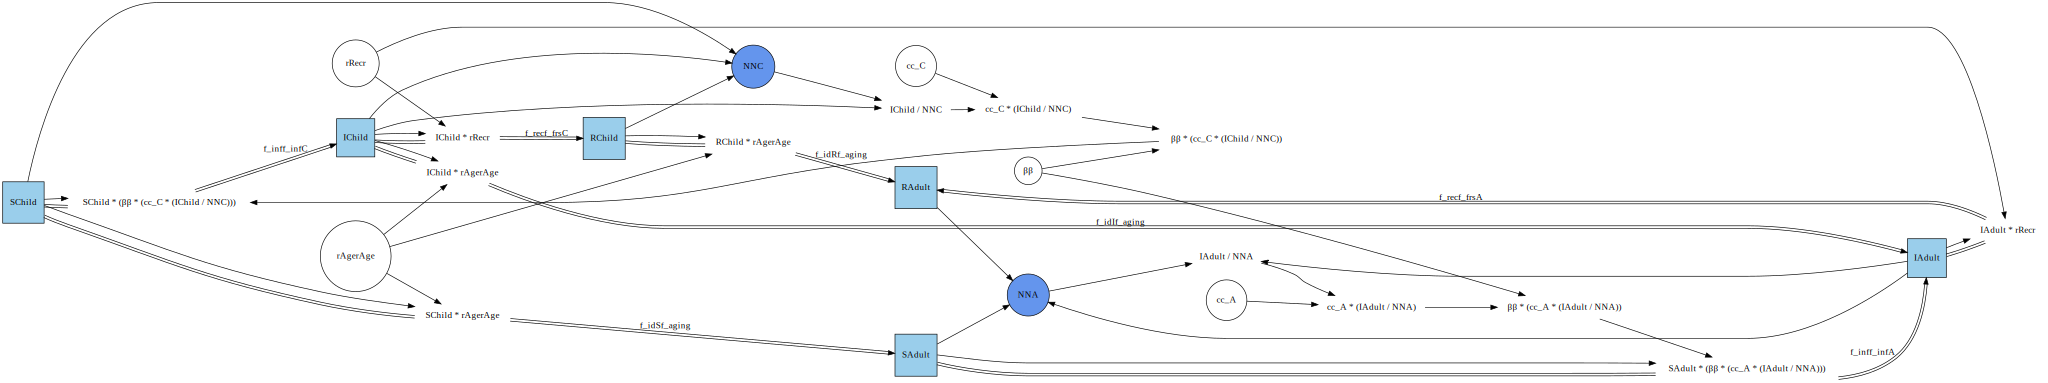

In [14]:
GraphF(aged_sir)

## 1.5 Graph Rewriting to correct the non_linear mixing part

In [15]:
aged_sir_rewritten = @rewrite aged_sir begin
    :redefs
    v_meanInfectiousContactsPerSv_cINC = cc_C * v_prevalencev_INC_post
    v_meanInfectiousContactsPerSv_cINA = cc_A * v_prevalencev_INA_post


    :parameters
    fcc
    fca
    fac
    faa

    :dynamic_variables


    v_CCContacts = fcc * v_prevalencev_INC
    v_CAContacts = fca * v_prevalencev_INA
    
    v_ACContacts = fac * v_prevalencev_INC
    v_AAContacts = faa * v_prevalencev_INA
    
    v_prevalencev_INC_post = v_CCContacts + v_CAContacts
    v_prevalencev_INA_post = v_ACContacts + v_AAContacts



end

StockAndFlowF {S:6, SV:2, LS:6, F:7, I:7, O:7, V:19, LV:9, LSV:2, P:9, LVV:14, LPV:13, Name:0, Op:0, Position:0}
┌───┬────────┐
│ S │  sname │
├───┼────────┤
│ 1 │ SChild │
│ 2 │ IChild │
│ 3 │ RChild │
│ 4 │ SAdult │
│ 5 │ IAdult │
│ 6 │ RAdult │
└───┴────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │    NNC │
│  2 │    NNA │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
│  4 │   4 │    2 │
│  5 │   5 │    2 │
│  6 │   6 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────────┐
│ F │ fv │        fname │
├───┼────┼──────────────┤
│ 1 │ 12 │  f_inff_infC │
│ 2 │ 13 │  f_recf_frsC │
│ 3 │ 14 │ f_idSf_aging │
│ 4 │ 15 │ f_idIf_aging │
│ 5 │ 16 │ f_idRf_aging │
│ 6 │ 18 │  f_inff_infA │
│ 7 │ 19 │  f_recf_frsA │
└───┴────┴──────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  2 │
│ 2 │   2 │  3 │
│ 3 │   3 │  4 │
│ 4 │   4 │  5 │
│ 5 │   6 │  5 │
│ 6 │   5 │  6 │
│ 7 │   7 │  6 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   3 │  1 │
│ 3 │   2 │  2 │
│ 4 │   4 │  2 │
│ 5 │   5 │  3 │
│ 6 │   6 │  4 │
│ 7 │   7 │  5 │
└───┴─────┴────┘
┌────┬────────────────────────────────────┬─────┐
│  V │                              vname │ vop │
├────┼────────────────────────────────────┼─────┤
│  1 │ v_meanInfectiousContactsPerSv_cINA │   * │
│  2 │                  v_prevalencev_INA │   / │
│  3 │                  v_prevalencev_INC │   / │
│  4 │ v_meanInfectiousContactsPerSv_cINC │   * │
│  5 │                       v_CCContacts │   * │
│  6 │                       v_CAContacts │   * │
│  7 │                       v_ACContacts │   * │
│  8 │                       v_AAContacts │   * │
│  9 │             v_prevalencev_INC_post │   + │
│ 10 │             v_prevalencev_INA_post │   + │
│ 11 │         v_perSIncidenceRatev_cβINC │   * │
│ 12 │              v_newInfectionsv_infC │   * │
│ 13 │                v_newRecoveryv_fstC │   * │
│ 14 │                      v_idSv_agingC │   * │
│ 15 │                      v_idIv_agingC │   * │
│ 16 │                      v_idRv_agingC │   * │
│ ⋮  │                 ⋮                  │  ⋮  │
└────┴────────────────────────────────────┴─────┘
                                   3 rows omitted
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   2 │   3 │           1 │
│  2 │   1 │  12 │           1 │
│  3 │   2 │  13 │           1 │
│  4 │   1 │  14 │           1 │
│  5 │   2 │  15 │           1 │
│  6 │   3 │  16 │           1 │
│  7 │   5 │   2 │           1 │
│  8 │   4 │  18 │           1 │
│  9 │   5 │  19 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    3 │             2 │
│   2 │     2 │    2 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬──────────┐
│ P │    pname │
├───┼──────────┤
│ 1 │     cc_A │
│ 2 │     cc_C │
│ 3 │      fcc │
│ 4 │      fca │
│ 5 │      fac │
│ 6 │      faa │
│ 7 │       ββ │
│ 8 │    rRecr │
│ 9 │ rAgerAge │
└───┴──────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     3 │     5 │             2 │
│   2 │     2 │     6 │             2 │
│   3 │     3 │     7 │             2 │
│   4 │     2 │     8 │             2 │
│   5 │     5 │     9 │             1 │
│   6 │     6 │     9 │             2 │
│   7 │     7 │    10 │             1 │
│   8 │     8 │    10 │             2 │
│   9 │     9 │     4 │             2 │
│  10 │    10 │     1 │             2 │
│  11 │     4 │    11 │             2 │
│  12 │    11 │    12 │             2 │
│  13 │     1 │    17 │             2 │
│  14 │    17 │    18 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├──

In [16]:
# define values of constant parameters
p_stratified_sir = LVector(
    fcc=0.8, fca=0.2, fac=0.2, faa=0.8, cc_C=0.45, cc_A=0.55,
    ββ=0.8, rRecr=1.0/14.0, rAgerAge=1.0/(15.0*365.0) #which means the child age group is from 0 to 15 years old
)
# define initial values for stocks
u0_stratified_sir = LVector(
    SChild=990.0, IChild=10.0, RChild=0.0,
    SAdult=4900.0, IAdult=10.0, RAdult=0.0
);

In [17]:
prob_stratified_sir = ODEProblem(vectorfield(aged_sir_rewritten),u0_stratified_sir,(0.0,100.0),p_stratified_sir);
sol_stratified_sir = solve(prob_stratified_sir,Tsit5(),abstol=1e-8);
plot(sol_stratified_sir)

In [ ]:
# to have the figures plotted fix to the wider of the cells
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")
